In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from mvf_bto.data_loading import load_data
from mvf_bto.constants import * 
from mvf_bto.models.baseline_lstm import BaselineLSTM, LSTMAutoregression
from mvf_bto.preprocessing import create_discharge_inputs
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import MeanSquaredError
from scipy.interpolate import interp1d

import numpy as np
import pandas as pd
import plotly
import plotly.graph_objects as go

2022-11-24 17:19:12.887775: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-24 17:19:12.887857: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Loading Data

In [3]:
data_path = "/home/amalss/Documents/CMU/Courses/10701/project/data/2017-05-12_batchdata_updated_struct_errorcorrect.mat"
# data_path = "/Users/anoushkabhutani/PycharmProjects/10701-mvf-bto/data/2017-05-12_batchdata_updated_struct_errorcorrect.mat"
# data_path = "/Users/mac/Desktop/CMU/10701MachineLearning/project/10701-mvf-bto-backup/data/2017-05-12_batchdata_updated_struct_errorcorrect.mat"

In [4]:
data = load_data(file_path=data_path, num_cells=4)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:47<00:00, 11.90s/it]


## Preprocessing to create model inputs and targets

In [5]:
train_split = 0.7
test_split = 0.2
# by default uses validation_split = 1 - (train_split + test_split)

In [6]:
datasets = create_discharge_inputs(data, train_split, test_split, forecast_horizon=9, history_window=10)
# Q_eval = np.linspace(0, 1, 

 Data for cell b1c3 is corrupted. Skipping cell.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1176/1176 [00:10<00:00, 116.46it/s]


## Train Model

In [7]:
window_length = datasets["X_train"].shape[1]
n_features = datasets["X_train"].shape[2]
batch_input_shape = (datasets["batch_size"], window_length, n_features)
n_outputs = datasets["y_train"].shape[-1]
nf_steps = datasets["y_train"].shape[1]
# y = datasets["y_train"][:, 0, 0]
# idx = y < 2.9
# weights = np.ones_like(y) * 1
# weights[idx] = 2

In [8]:
print(datasets["X_train"].shape)
print(datasets["y_train"].shape[0])

(1177, 9, 4)
1177


In [20]:
# model = BaselineLSTM(batch_input_shape=batch_input_shape, n_outputs=n_outputs, nf_steps=nf_steps)
from mvf_bto.models.baseline_lstm import BaselineLSTM, LSTMAutoregression

model = LSTMAutoregression(n_outputs=n_outputs, out_steps=9)

In [21]:
import tensorflow as tf
def custom_loss(y_actual, y_pred):
    # print(y_actual)
    custom_loss = tf.square(y_actual[:, :, 0]-y_pred[:, :, 0]) + tf.square(y_actual[:, :, 2]-y_pred[:, :, 2])
    custom_loss = tf.reduce_mean(custom_loss, 1)
    # print(custom_loss)
    return custom_loss
    # return 0.5 * custom_loss

# def custom_loss_function(y_true, y_pred):   
#     split = y_true.shape[-1]//2
#     return tf.reduce_mean((y_true[:,:split]-y_pred[:,:split])**2 + 10*(y_true[:,split:]-y_pred[:,split:])**2, axis=-1)
# model.compile(optimizer='adam', loss=custom_loss_function)

model.compile(optimizer="adam", loss=custom_loss, metrics=[MeanSquaredError()])
model.build(batch_input_shape)
model.summary()
es = EarlyStopping(
    monitor="val_mean_squared_error",
    min_delta=0,
    patience=10,
    verbose=1,
    mode="auto",
    restore_best_weights=True,
)

history = model.fit(
    datasets["X_train"],
    datasets["y_train"],
    validation_data=(datasets["X_val"], datasets["y_val"]),
    epochs=250,
    batch_size=datasets["batch_size"],
    shuffle=False,
    callbacks=[es],
    verbose=1,
)

Model: "lstm_autoregression_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_cell_1 (LSTMCell)      multiple                  4736      
                                                                 
 rnn_1 (RNN)                 multiple                  4736      
                                                                 
 dense_2 (Dense)             multiple                  1056      
                                                                 
 dense_3 (Dense)             multiple                  264       
                                                                 
 dense_4 (Dense)             multiple                  36        
                                                                 
Total params: 6,092
Trainable params: 6,092
Non-trainable params: 0
_________________________________________________________________
Epoch 1/250
1177/1177 [====================

In [22]:
fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=np.linspace(1, 50),
        y=history.history["loss"],
        showlegend=False,
        mode="markers+lines",
    )
)
fig.update_xaxes(title="Epochs")
fig.update_yaxes(title="Loss (MSE)")
fig.update_layout(height=500)

## Parity Plot of Training Error

In [23]:
# random plotting traing error at some interval = skip to not make the plot rendering too slow
batch_size = datasets["batch_size"]
print(batch_size)
skip = 70

fig = go.Figure()
fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1], showlegend=False, mode="markers+lines"))
for i in range(0, len(datasets["X_train"]), batch_size * skip):
    # print(i)
    df_pred = pd.DataFrame(model.predict(datasets["X_train"][i : i + batch_size], verbose=0)[:, :, 0])
    df_train = pd.DataFrame(datasets["y_train"][i : i + batch_size][:, :, 0])
    # print(df_pred.values[0])
    fig.add_trace(
        go.Scatter(
            x=df_pred.values[0],
            y=df_train.values[0],
            showlegend=False,
            mode="markers+lines",
        )
    )

fig.update_yaxes(title="Normalized Temperature Target")
fig.update_xaxes(title="Normalized Temperature Prediction")
fig.update_layout(template="simple_white")
fig.update_layout(height=500)

1


In [24]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1], showlegend=False, mode="markers+lines"))
for i in range(0, len(datasets["X_train"]), batch_size * skip):
    df_pred = pd.DataFrame(model.predict(datasets["X_train"][i : i + batch_size], verbose=0)[:, :, 2])
    df_train = pd.DataFrame(datasets["y_train"][i : i + batch_size][:, :, 2])
    fig.add_trace(
        go.Scatter(
            x=df_pred.values[0],
            y=df_train.values[0],
            showlegend=False,
            mode="markers+lines",
        )
    )

fig.update_yaxes(title="Normalized Voltage Target")
fig.update_xaxes(title="Normalized Voltage Prediction")
fig.update_layout(template="simple_white")
fig.update_layout(height=500)

## Parity Plot of Test Error

In [25]:
skip = 20

fig = go.Figure()
fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1], showlegend=False, mode="markers+lines"))
for i in range(0, len(datasets["X_test"]), batch_size * skip):
    df_pred = pd.DataFrame(model.predict(datasets["X_test"][i : i + batch_size], verbose=0)[:, :, 0])
    df_train = pd.DataFrame(datasets["y_test"][i : i + batch_size][:, :, 0])
    fig.add_trace(
        go.Scatter(
            x=df_pred.values[0],
            y=df_train.values[0],
            showlegend=False,
            mode="markers+lines",
        )
    )

fig.update_yaxes(title="Normalized Temperature Target")
fig.update_xaxes(title="Normalized Temperature Prediction")
fig.update_layout(template="simple_white")
fig.update_layout(height=500)

In [26]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1], showlegend=False, mode="markers+lines"))
for i in range(0, len(datasets["X_test"]), batch_size * skip):
    df_pred = pd.DataFrame(model.predict(datasets["X_test"][i : i + batch_size], verbose=0)[:, :, 2])
    df_train = pd.DataFrame(datasets["y_test"][i : i + batch_size][:, :, 2])
    fig.add_trace(
        go.Scatter(
            x=df_pred.values[0],
            y=df_train.values[0],
            showlegend=False,
            mode="markers+lines",
        )
    )

fig.update_yaxes(title="Normalized Voltage Target")
fig.update_xaxes(title="Normalized Voltage Prediction")
fig.update_layout(template="simple_white")
fig.update_layout(height=500)

## True vs Predicted Traces (Train Set)

In [27]:
symbol_list = ["circle-open", "circle", "triangle-up"]
pallete = plotly.colors.qualitative.Dark24 + plotly.colors.qualitative.T10
pallete = pallete*70000

In [28]:
train_cell_ids = list(datasets['original_train']['Cell'].unique())
test_cell_ids = list(datasets['original_test']['Cell'].unique())
val_cell_ids = list(datasets['original_val']['Cell'].unique())

1177


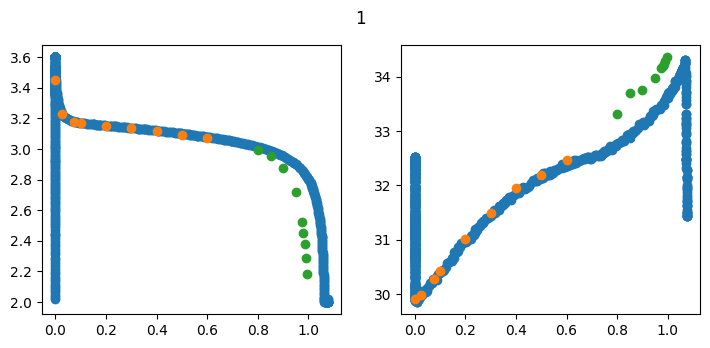

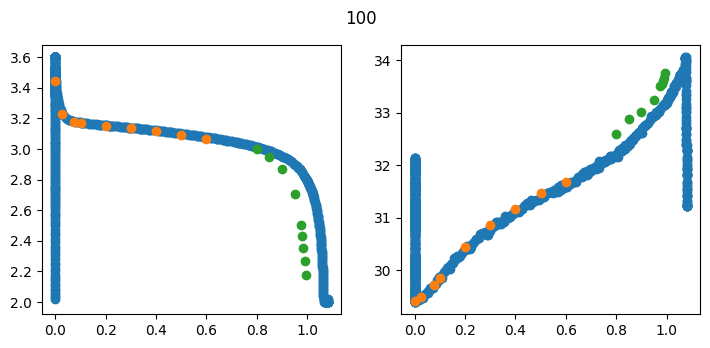

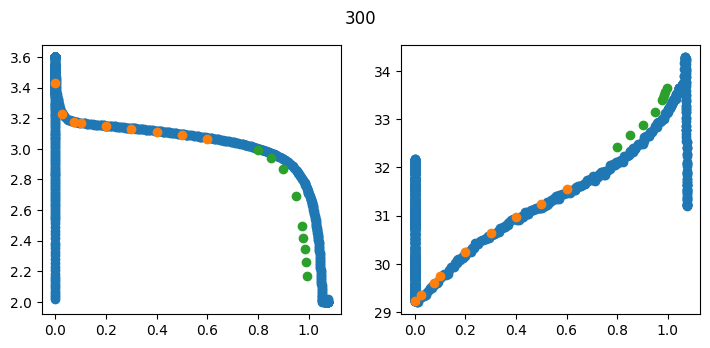

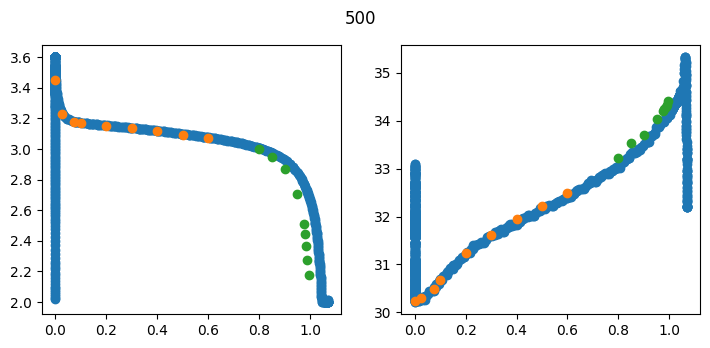

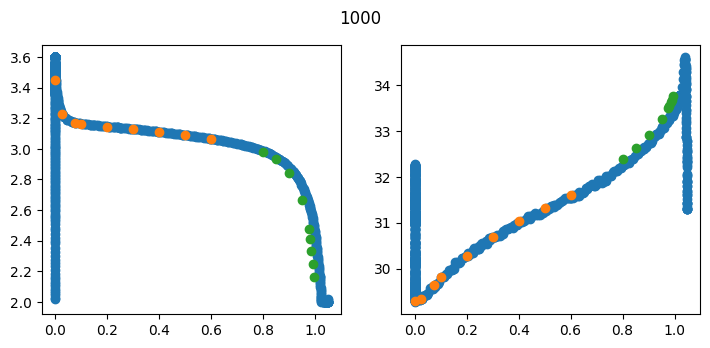

In [29]:
full_data_cycle_no = datasets['original_train'].Cycle
print(max(full_data_cycle_no))

cycle_plots = [1, 100, 300, 500, 1000] 

for cycle_plot in cycle_plots:
    input = datasets["X_train"][cycle_plot-1:cycle_plot]
    # print(input.shape)
    output = model.predict(input, verbose=0)
    # print(output.shape)
    
    # print(datasets['original_train'].keys())
    full_data_V = datasets['original_train'].V
    full_data_Qd = datasets['original_train'].Qd
    full_data_T = datasets['original_train'].temp
    
    from constants import REFERENCE_DISCHARGE_CAPACITIES as Q_output
    # print(full_data)
    import matplotlib.pyplot as plt
    Q_input = input[0][:, 1]
    # print(full_data_Qd[:20000])
    idx = full_data_cycle_no == cycle_plot
    # print(idx)
    # print(full_data_cycle_no)
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(8.5, 3.5)
    fig.suptitle(str(cycle_plot))
    
    # print(Q_input, Q_output[9:12])
    ax1.scatter(full_data_Qd[idx], full_data_V[idx])
    ax1.scatter(Q_input, input[0][:,2]*(VOLTAGE_MAX - VOLTAGE_MIN) + VOLTAGE_MIN)
    ax1.scatter(Q_output[9:18], output[0][:, 2]*(VOLTAGE_MAX - VOLTAGE_MIN) + VOLTAGE_MIN)
    # plt.scatter(Q_input[11:], output[0][:, 2]*(VOLTAGE_MAX - VOLTAGE_MIN) + VOLTAGE_MIN)
    
    
    # plt.figure()
    ax2.scatter(full_data_Qd[idx], full_data_T[idx])
    ax2.scatter(Q_input, input[0][:, 0]*(TEMPERATURE_MAX - TEMPERATURE_MIN) + TEMPERATURE_MIN)
    ax2.scatter(Q_output[9:18], output[0][:, 0]*(TEMPERATURE_MAX - TEMPERATURE_MIN) + TEMPERATURE_MIN)
    # plt.title(str(cycle_plot))
    # plt.show()
    # plt.clf()
    # plt.ylim(0, 50)
    

1188


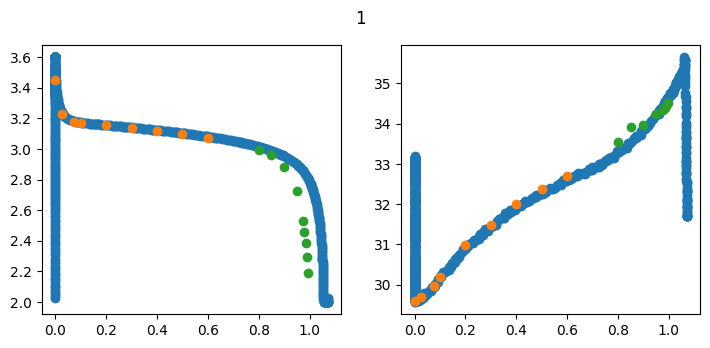

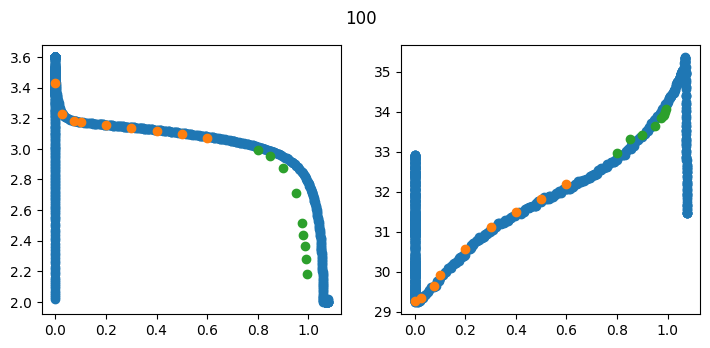

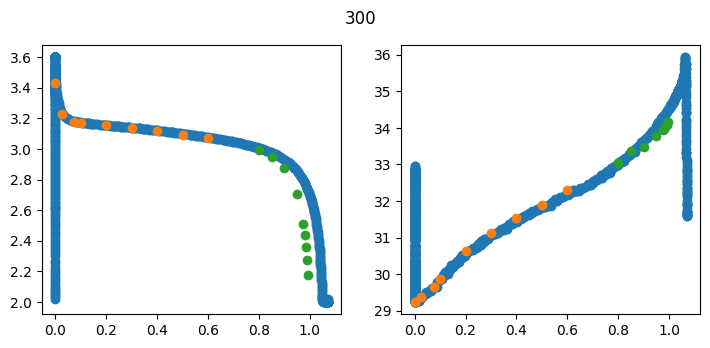

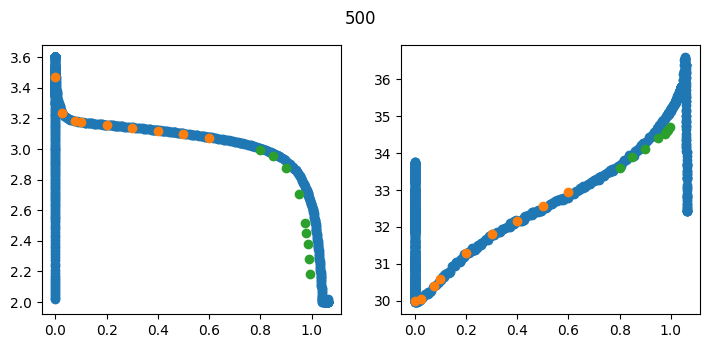

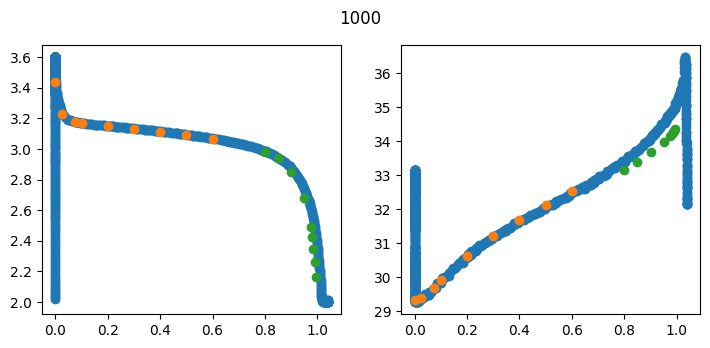

In [30]:
full_data_cycle_no = datasets['original_test'].Cycle
print(max(full_data_cycle_no))

cycle_plots = [1, 100, 300, 500, 1000] 

for cycle_plot in cycle_plots:
    input = datasets["X_test"][cycle_plot-1:cycle_plot]
    # print(input.shape)
    output = model.predict(input, verbose=0)
    # print(output.shape)
    
    # print(datasets['original_train'].keys())
    full_data_V = datasets['original_test'].V
    full_data_Qd = datasets['original_test'].Qd
    full_data_T = datasets['original_test'].temp
    
    from constants import REFERENCE_DISCHARGE_CAPACITIES as Q_output
    # print(full_data)
    import matplotlib.pyplot as plt
    Q_input = input[0][:, 1]
    # print(full_data_Qd[:20000])
    idx = full_data_cycle_no == cycle_plot
    # print(idx)
    # print(full_data_cycle_no)
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(8.5, 3.5)
    fig.suptitle(str(cycle_plot))
    # print(Q_input, Q_output[9:18])
    
    ax1.scatter(full_data_Qd[idx], full_data_V[idx])
    ax1.scatter(Q_input, input[0][:,2]*(VOLTAGE_MAX - VOLTAGE_MIN) + VOLTAGE_MIN)
    ax1.scatter(Q_output[9:18], output[0][:, 2]*(VOLTAGE_MAX - VOLTAGE_MIN) + VOLTAGE_MIN)
    # print(datasets["y_test"][cycle_plot-1:cycle_plot][0][:, 1], Q_output[9:18])
    
    
    # plt.figure()
    ax2.scatter(full_data_Qd[idx], full_data_T[idx])
    ax2.scatter(Q_input, input[0][:, 0]*(TEMPERATURE_MAX - TEMPERATURE_MIN) + TEMPERATURE_MIN)
    ax2.scatter(Q_output[9:18], output[0][:, 0]*(TEMPERATURE_MAX - TEMPERATURE_MIN) + TEMPERATURE_MIN)
    # plt.title(str(cycle_plot))
    # plt.show()
    # plt.clf()
    # plt.ylim(0, 50)
    

In [ ]:
skip = 500
train_cell_id_idx = 0
last_cycle = 1
current_cycle = 1
opacity_list = [1, 0.6, 0.3]
fig = go.Figure()

# print(model(datasets["X_train"]))

for i in range(0, len(datasets["X_train"]), skip):
    df_true = pd.DataFrame(datasets["y_train"][i][:, 2])
    
    last_cycle = current_cycle
    current_cycle = int(datasets["X_train"][i][0][-1]*MAX_CYCLE)
    if current_cycle>740:
        continue
    if last_cycle> current_cycle:
        train_cell_id_idx += 1
    cell_id = train_cell_ids[train_cell_id_idx]
    original_df = datasets["original_train"]
    original_df= original_df[original_df.Cycle==current_cycle]
    original_df= original_df[original_df.Cell==cell_id]
    original_df = original_df[original_df.I < MAX_DISCHARGE_CURRENT]
    original_df = original_df[original_df.I > MIN_DISCHARGE_CURRENT]

    original_df['Qd'] = (original_df['Qd']-original_df['Qd'].min())/(original_df['Qd'].max()-original_df['Qd'].min())

    if len(original_df)< 2:
        continue
    q_new = original_df.Qd.values
    t_new = original_df['t'].values
    time_interpolator = interp1d(x = q_new,  y = t_new, fill_value="extrapolate")
    
    # print(model.predict(datasets["X_train"][i : i + 7], verbose=0), i)
    for j in range(1):
        df_pred = pd.DataFrame(model.predict(datasets["X_train"][i:i+1], verbose=0)[:, 2])
    
        ref_capacities_wrt_nf = REFERENCE_DISCHARGE_CAPACITIES[9:18]
        print(len(df_pred.values))
        prediction_interpolator = interp1d(x = ref_capacities_wrt_nf, 
                                           y = df_pred[0].values*(VOLTAGE_MAX - VOLTAGE_MIN) + VOLTAGE_MIN,
                                          )
        
        q_j = q_new[q_new>= min(REFERENCE_DISCHARGE_CAPACITIES[9:18])]
        q_j = q_j[q_j<= max(REFERENCE_DISCHARGE_CAPACITIES[9:18])]
        t_interp = time_interpolator(REFERENCE_DISCHARGE_CAPACITIES[9:18])
        # if j==0:
        #     q_j0 = q_j
        V_pred = prediction_interpolator(q_j)
        fig.add_trace(
            go.Scatter(
                x=time_interpolator(q_j),
                y=V_pred,
                showlegend=True,
                mode="lines",
                line_dash="dash",
                name = "Interpolated Predictions",
                marker_color=pallete[i],
                opacity=opacity_list[j]
            )
        )
        
        fig.add_trace(
            go.Scatter(
                x=time_interpolator(ref_capacities_wrt_nf),
                y=df_pred[0].values*(VOLTAGE_MAX - VOLTAGE_MIN) + VOLTAGE_MIN,
                showlegend=True,
                mode="markers",
                name = f"Predictions Forecast Horizon {j+1}",
                marker_color=pallete[i],
                marker_symbol = symbol_list[j],
                marker_size=8,
                marker_opacity=opacity_list[j]
            )
        )

    odf = original_df[original_df.Qd > q_j0.min()]
    odf = odf[odf.Qd < q_j.max()]
    fig.add_trace(
        go.Scatter(
            x=odf['t'],
            y=odf['V'],
            showlegend=True,
            mode="lines",
            name = f"{cell_id} Cycle {current_cycle}",
            line_color=pallete[i]
        )
    )


fig.update_yaxes(title="Voltage [V]", showgrid=True)
fig.update_xaxes(title="Times (min)", showgrid=True)
fig.update_layout(template="simple_white")
fig.update_layout(height=500)

In [ ]:
train_cell_id_idx = 0
last_cycle = 1
current_cycle = 1

fig = go.Figure()
for i in range(0, len(datasets["X_train"]), batch_size * skip):
    df_true = pd.DataFrame(datasets["y_train"][i : i + batch_size][:, 0, 1])
    
    last_cycle = current_cycle
    current_cycle = int(datasets["X_train"][i : i + batch_size][0][0][-1]*MAX_CYCLE)
    if current_cycle>740:
        continue
    if last_cycle> current_cycle:
        train_cell_id_idx += 1
        
    cell_id = train_cell_ids[train_cell_id_idx]
    original_df = datasets["original_train"]

    original_df= original_df[original_df.Cycle==current_cycle]
    original_df= original_df[original_df.Cell==cell_id]
    original_df = original_df[original_df.I < MAX_DISCHARGE_CURRENT]
    original_df = original_df[original_df.I > MIN_DISCHARGE_CURRENT]

    original_df['Qd'] = (original_df['Qd']-original_df['Qd'].min())/(original_df['Qd'].max()-original_df['Qd'].min())

    if len(original_df)< 2:
        continue
    q_new = original_df.Qd.values
    t_new = original_df['t'].values
    time_interpolator = interp1d(x = q_new,  y = t_new, fill_value="extrapolate")
    
    
    for j in range(1):
        df_pred = pd.DataFrame(model.predict(datasets["X_train"][i : i + batch_size], verbose=0)[:, j, 1])
    
        ref_capacities_wrt_nf = REFERENCE_DISCHARGE_CAPACITIES[window_length+j:-nf_steps+j-1]

        prediction_interpolator = interp1d(x = ref_capacities_wrt_nf, 
                                           y = df_pred[0].values*(TEMPERATURE_MAX - TEMPERATURE_MIN) + TEMPERATURE_MIN,
                                           
                                          )
        
        q_j = q_new[q_new>= min(REFERENCE_DISCHARGE_CAPACITIES[window_length+j:-nf_steps+j-1])]
        q_j = q_j[q_j<= max(REFERENCE_DISCHARGE_CAPACITIES[window_length+j:-nf_steps+j-1])]
        t_interp = time_interpolator(REFERENCE_DISCHARGE_CAPACITIES[window_length:-nf_steps-1])
        if j==0:
            q_j0 = q_j
        V_pred = prediction_interpolator(q_j)
        fig.add_trace(
            go.Scatter(
                x=time_interpolator(q_j),
                y=V_pred,
                showlegend=True,
                mode="lines",
                line_dash="dash",
                name = "Interpolated Predictions",
                marker_color=pallete[i//skip],
                opacity=opacity_list[j]
            )
        )
        
        fig.add_trace(
            go.Scatter(
                x=time_interpolator(ref_capacities_wrt_nf),
                y=df_pred[0].values*(TEMPERATURE_MAX - TEMPERATURE_MIN) + TEMPERATURE_MIN,
                showlegend=True,
                mode="markers",
                name = f"Predictions Forecast Horizon {j+1}",
                marker_color=pallete[i//skip],
                marker_symbol = symbol_list[j],
                marker_size=8,
            )
        )


    odf = original_df[original_df.Qd > q_j0.min()]
    odf = odf[odf.Qd < q_j.max()]
    fig.add_trace(
        go.Scatter(
            x=odf['t'],
            y=odf['temp'],
            showlegend=True,
            mode="lines",
            name = f"{cell_id} Cycle {current_cycle}",
            line_color=pallete[i//skip]
        )
    )


fig.update_yaxes(title="Temperature [°C]", showgrid=True)
fig.update_xaxes(title="Times (min)", showgrid=True)
fig.update_layout(template="simple_white")
fig.update_layout(height=500)

## True vs Predicted Traces (Test Set)

In [ ]:
skip = 300
test_cell_id_idx = 0
last_cycle = 1
current_cycle = 1
opacity_list = [1, 0.6, 0.3]
fig = go.Figure()
for i in range(0, len(datasets["X_test"]), batch_size * skip):
    df_true = pd.DataFrame(datasets["y_test"][i : i + batch_size][:, 0, 0])
    
    last_cycle = current_cycle
    current_cycle = int(datasets["X_test"][i : i + batch_size][0][0][-1]*MAX_CYCLE)

    if last_cycle> current_cycle:
        test_cell_id_idx += 1
        
    cell_id = test_cell_ids[test_cell_id_idx]
    original_df = datasets["original_test"]

    original_df= original_df[original_df.Cycle==current_cycle]
    original_df= original_df[original_df.Cell==cell_id]
    original_df = original_df[original_df.I < MAX_DISCHARGE_CURRENT]
    original_df = original_df[original_df.I > MIN_DISCHARGE_CURRENT]

    original_df['Qd'] = (original_df['Qd']-original_df['Qd'].min())/(original_df['Qd'].max()-original_df['Qd'].min())

    if len(original_df)< 2:
        continue
    q_new = original_df.Qd.values
    t_new = original_df['t'].values
    time_interpolator = interp1d(x = q_new,  y = t_new, fill_value="extrapolate")
    
    
    for j in range(nf_steps):
        df_pred = pd.DataFrame(model.predict(datasets["X_test"][i : i + batch_size], verbose=0)[:, j, 0])
    
        ref_capacities_wrt_nf = REFERENCE_DISCHARGE_CAPACITIES[window_length+j:-nf_steps+j-1]

        prediction_interpolator = interp1d(x = ref_capacities_wrt_nf, 
                                           y = df_pred[0].values*(VOLTAGE_MAX - VOLTAGE_MIN) + VOLTAGE_MIN,
                                           
                                          )
        
        q_j = q_new[q_new>= min(REFERENCE_DISCHARGE_CAPACITIES[window_length+j:-nf_steps+j-1])]
        q_j = q_j[q_j<= max(REFERENCE_DISCHARGE_CAPACITIES[window_length+j:-nf_steps+j-1])]
        t_interp = time_interpolator(REFERENCE_DISCHARGE_CAPACITIES[window_length:-nf_steps-1])
        if j==0:
            q_j0 = q_j
        V_pred = prediction_interpolator(q_j)
        fig.add_trace(
            go.Scatter(
                x=time_interpolator(q_j),
                y=V_pred,
                showlegend=True,
                mode="lines",
                line_dash="dash",
                name = "Interpolated Predictions",
                marker_color=pallete[i//skip],
                opacity=opacity_list[j]
            )
        )
        
        fig.add_trace(
            go.Scatter(
                x=time_interpolator(ref_capacities_wrt_nf),
                y=df_pred[0].values*(VOLTAGE_MAX - VOLTAGE_MIN) + VOLTAGE_MIN,
                showlegend=True,
                mode="markers",
                name = f"Predictions Forecast Horizon {j+1}",
                marker_color=pallete[i//skip],
                marker_symbol = symbol_list[j],
                marker_size=8,
                marker_opacity=opacity_list[j]
            )
        )


    odf = original_df[original_df.Qd > q_j0.min()]
    odf = odf[odf.Qd < q_j.max()]
    fig.add_trace(
        go.Scatter(
            x=odf['t'],
            y=odf['V'],
            showlegend=True,
            mode="lines",
            name = f"{cell_id} Cycle {current_cycle}",
            line_color=pallete[i//skip]
        )
    )


fig.update_yaxes(title="Voltage [V]", showgrid=True)
fig.update_xaxes(title="Times (min)", showgrid=True)
fig.update_layout(template="simple_white")

In [ ]:
test_cell_id_idx = 0
last_cycle = 1
current_cycle = 1

fig = go.Figure()
for i in range(0, len(datasets["X_test"]), batch_size * skip):
    
    last_cycle = current_cycle
    current_cycle = int(datasets["X_test"][i : i + batch_size][0][0][-1]*MAX_CYCLE)
    
    if last_cycle> current_cycle:
        test_cell_id_idx += 1
        
    cell_id = test_cell_ids[test_cell_id_idx]
    original_df = datasets["original_test"]

    original_df= original_df[original_df.Cycle==current_cycle]
    original_df= original_df[original_df.Cell==cell_id]
    original_df = original_df[original_df.I < MAX_DISCHARGE_CURRENT]
    original_df = original_df[original_df.I > MIN_DISCHARGE_CURRENT]

    original_df['Qd'] = (original_df['Qd']-original_df['Qd'].min())/(original_df['Qd'].max()-original_df['Qd'].min())

    if len(original_df)< 2:
        continue
    q_new = original_df.Qd.values
    t_new = original_df['t'].values
    time_interpolator = interp1d(x = q_new,  y = t_new, fill_value="extrapolate")
    
    
    for j in range(nf_steps):
        df_pred = pd.DataFrame(model.predict(datasets["X_test"][i : i + batch_size], verbose=0)[:, j, 1])
    
        ref_capacities_wrt_nf = REFERENCE_DISCHARGE_CAPACITIES[window_length+j:-nf_steps+j-1]

        prediction_interpolator = interp1d(x = ref_capacities_wrt_nf, 
                                           y = df_pred[0].values*(TEMPERATURE_MAX - TEMPERATURE_MIN) + TEMPERATURE_MIN,
                                           
                                          )
        
        q_j = q_new[q_new>= min(REFERENCE_DISCHARGE_CAPACITIES[window_length+j:-nf_steps+j-1])]
        q_j = q_j[q_j<= max(REFERENCE_DISCHARGE_CAPACITIES[window_length+j:-nf_steps+j-1])]
        t_interp = time_interpolator(REFERENCE_DISCHARGE_CAPACITIES[window_length:-nf_steps-1])
        if j==0:
            q_j0 = q_j
        V_pred = prediction_interpolator(q_j)
        fig.add_trace(
            go.Scatter(
                x=time_interpolator(q_j),
                y=V_pred,
                showlegend=True,
                mode="lines",
                line_dash="dash",
                name = "Interpolated Predictions",
                marker_color=pallete[i//skip],
                opacity=opacity_list[j]
            )
        )
        
        fig.add_trace(
            go.Scatter(
                x=time_interpolator(ref_capacities_wrt_nf),
                y=df_pred[0].values*(TEMPERATURE_MAX - TEMPERATURE_MIN) + TEMPERATURE_MIN,
                showlegend=True,
                mode="markers",
                name = f"Predictions Forecast Horizon {j+1}",
                marker_color=pallete[i//skip],
                marker_symbol = symbol_list[j],
                marker_size=8,
#                 marker_opacity=opacity_list[j]
            )
        )


    odf = original_df[original_df.Qd > q_j0.min()]
    odf = odf[odf.Qd < q_j.max()]
    fig.add_trace(
        go.Scatter(
            x=odf['t'],
            y=odf['temp'],
            showlegend=True,
            mode="lines",
            name = f"{cell_id} Cycle {current_cycle}",
            line_color=pallete[i//skip]
        )
    )


fig.update_yaxes(title="Temperature [°C]", showgrid=True)
fig.update_xaxes(title="Times (min)", showgrid=True)
fig.update_layout(template="simple_white")

## Metrics

In [ ]:
def error_calculation(model, datasets, error_function):
    results = {}
    batch_size = datasets["batch_size"]
    n_outputs = datasets["y_train"].shape[-1]
    nf_steps = datasets["y_train"].shape[1]
    for dset in ["train", "test"]:
        skip = 200 if dset == "train"  else 50
        for output in range(n_outputs):
            for step in range(nf_steps):
                collector = []
                for i in range(0, len(datasets[f"X_{dset}"]), batch_size*skip):
                    true = datasets[f"y_{dset}"][i : i + batch_size][:, j, output]
                    pred = model.predict(datasets[f"X_{dset}"][i : i + batch_size], verbose=0)[:, j, output]
                    error = error_function(true, pred)
                    collector.append(error)
                results[f"{dset}_output{output}_forecasthorizon{step}"] =sum(collector)/len(collector)
                         
    return results

In [ ]:
root_mean_square_error = lambda y_true, y_pred : np.sqrt(((y_true - y_pred)**2).sum()/len(y_true))
mean_absolute_error = lambda y_true, y_pred : abs(y_true - y_pred).sum()/len(y_true)
mean_absolute_percent_error = lambda y_true, y_pred : (abs(y_true - y_pred)/y_true).sum()/len(y_true)

In [ ]:
error_calculation(model, datasets, error_function=mean_absolute_error)